### Necessary Packages

In [1]:
import sys
import os
import numpy as np
sys.path.append('..')
import torch
import definitions as D
import matplotlib.pyplot as plt
import imageio
from torch import Tensor
from src.models import VQVAE,UNet
from src.utils import get_last_checkpoint,load_json
from src.training.vqvae import Config as VQVAEConfig
from src.training.diffusion import Config as DiffusionConfig
from src.transforms import NoiseScheduler
from tqdm.notebook import tqdm
from src.utils import make_grid
from IPython import display

### Load configurations

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
VQVAE_EXPIREMENT = 'vqvae'
DIFFUSION_EXPIREMENT = 'diffusion'

In [4]:
VQVAE_CONFIG = os.path.join(D.EXPERIMENTS_DIR,VQVAE_EXPIREMENT,'config.json')
UNET_CONFIG = os.path.join(D.EXPERIMENTS_DIR,DIFFUSION_EXPIREMENT,'config.json')

In [5]:
vqvae_config = VQVAEConfig(**load_json(VQVAE_CONFIG))
unet_config = DiffusionConfig(**load_json(UNET_CONFIG))

### Load models

In [6]:
VQVAE_CHECKPOINT = os.path.join(D.EXPERIMENTS_DIR,VQVAE_EXPIREMENT,'checkpoints')
UNET_CHECKPOINT = os.path.join(D.EXPERIMENTS_DIR,DIFFUSION_EXPIREMENT,'checkpoints')

In [7]:
vqvae_state_dict = get_last_checkpoint(VQVAE_CHECKPOINT)['vqvae']
unet_state_dict = get_last_checkpoint(UNET_CHECKPOINT)

In [8]:
vqvae = VQVAE(**vqvae_config.vqvae_args).to(DEVICE).eval()
vqvae.load_state_dict(vqvae_state_dict)

<All keys matched successfully>

In [9]:
diffusion = UNet(
    in_channels = unet_config.in_channels,
    out_channels = unet_config.out_channels,
    down_channels = unet_config.down_channels,
    mid_channels = unet_config.mid_channels,
    num_layers = unet_config.num_layers,
    norm_channels = unet_config.norm_channels,
    num_heads = unet_config.num_heads,
    t_emb_dim = unet_config.t_emb_dim,
    output_activation = unet_config.output_activation,
).to(DEVICE).eval()

In [10]:
diffusion.load_state_dict(unet_state_dict)

<All keys matched successfully>

### Test

In [11]:
scheduler = NoiseScheduler(
    timesteps=unet_config.timesteps,
    beta_start=unet_config.beta_start,
    beta_end=unet_config.beta_end
).to(DEVICE)

In [12]:
def generate_image(
    vqvae: VQVAE,
    diffusion: UNet,
    scheduler: NoiseScheduler,
    device: torch.device,
    noise_shape: tuple,
    decode_every : int | None = 10
) -> Tensor:
    
    image = torch.randn(noise_shape).to(device)
    num_steps = scheduler.timesteps
    images = []

    with torch.inference_mode():

        for t in tqdm(reversed(range(num_steps)), total=num_steps):

            t = torch.tensor(t).repeat(image.size(0)).to(device)
            noise = diffusion(image, t)
            image,x0 = scheduler.denoise(image, noise, t)

            if (decode_every is not None and t[0].item() % decode_every == 0) or t[0].item() == 0:
                x0 = vqvae.decoder(x0)
                x0 = (x0 + 1) / 2
                x0 = x0.detach().cpu()
                images.append(x0)

    images = torch.stack(images)

    return images

In [13]:
images = generate_image(vqvae,diffusion,scheduler,DEVICE,(16,3,16,16),decode_every=10)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
grid = make_grid(images[-1],4,4,4,1.0)

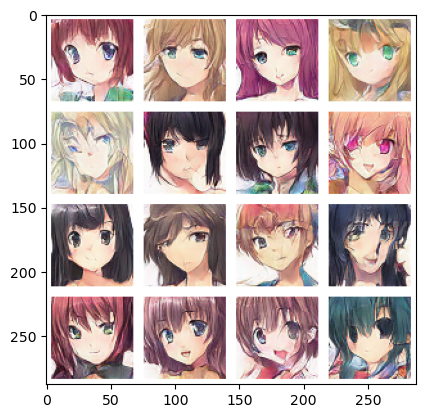

In [15]:
plt.imshow(grid)

In [16]:
grid = make_grid(images,4,4,4,1.0)
grid = 255 * grid
grid = grid.type(torch.uint8)

In [17]:
frames = list(grid.numpy())

In [18]:
gif_path = os.path.join(D.EXPERIMENTS_DIR,DIFFUSION_EXPIREMENT,'images.gif')

In [19]:
imageio.mimsave(gif_path,frames)

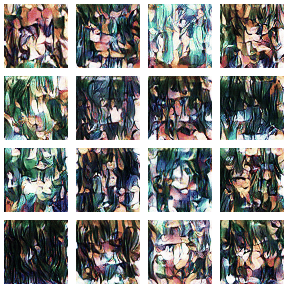

In [20]:
display.Image(filename=gif_path)